# IA for HumanForYou : Predictive Analytics and Attrition Factors

| Project Group Members | Role |
| :--- | :--- |
| **El Meskine Anas** | ** |
| **Haider Maisam** | ** |
| **Ferchichi Haifa** | ** |
| **Gautier Quentin** | ** |

### 🎯 Context and Objectives
The pharmaceutical company **HumanForYou** faces a significant challenge: an annual employee turnover rate of approximately **15%**. This attrition leads to project delays, loss of expertise, and high recruitment costs.

**Our Mission:**
1.  Analyze HR data to understand the **root causes** of employee departure.
2.  Develop a **predictive AI model** to identify employees at risk.
3.  Propose concrete **strategic recommendations** to improve retention.

## Table of Contents

* [1. Data Preparation & Engineering](#1-data-preparation--engineering)
* [2. Exploratory Data Analysis (EDA)]()
* [3. Modeling & Improvement Strategy]()
* [4. Model Evaluation & Interpretation]()
* [5. Conclusion & Recommendations]()

## 1. Data Preparation & Engineering

To build a reliable model, we first aggregated data from five different sources (HR info, Manager surveys, Employee surveys, and Time logs).

**Key Engineering Decisions:**
* **Data Imputation:** Instead of discarding incomplete rows (which would lose valuable information), we imputed missing numerical values with the **median** and categorical values with the **mode**.
* **Feature Engineering (`AverageWorkingHours`):** The raw data provided daily check-in/check-out times (`in_time`, `out_time`) but no summary of workload. We calculated the **average daily working duration** for each employee. This engineered feature proved critical, as we hypothesized a strong link between burnout and attrition.
* **Encoding:** Categorical variables (e.g., *Department*, *JobRole*) were transformed using **One-Hot Encoding** to be machine-readable.

### 1.1 Data Loading and Initial Cleaning

**Objective:** aggregate the 5 scattered CSV files into a single usable dataframe.

**Methodology & Justification:**
* **Missing Values Strategy:** We detected missing values in `NumCompaniesWorked`, `TotalWorkingYears`, and survey satisfaction scores.
    * *Decision:* We chose **Imputation** over deletion.
    * *Why?* Deleting rows would reduce our dataset size and potentially introduce bias. We replace missing numerical values with the **Median** (robust to outliers) and categorical values with the **Mode** (most frequent category).

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np

# Load the datasets
general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# Inspect General Data
print("--- General Data Info ---")
print(general_data.info())
print("\n--- General Data Head ---")
print(general_data.head())

# Inspect Employee Survey
print("\n--- Employee Survey Info ---")
print(employee_survey.info())
print("\n--- Employee Survey Head ---")
print(employee_survey.head())

# Inspect Manager Survey
print("\n--- Manager Survey Info ---")
print(manager_survey.info())
print("\n--- Manager Survey Head ---")
print(manager_survey.head())

# Inspect In Time
print("\n--- In Time Info ---")
print(in_time.info())
print("\n--- In Time Head ---")
print(in_time.iloc[:, :5].head()) # Show first 5 cols

# Inspect Out Time
print("\n--- Out Time Info ---")
print(out_time.info())
print("\n--- Out Time Head ---")
print(out_time.iloc[:, :5].head())

--- General Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14

### 1.2 Feature Engineering: The "Burnout" Indicator

**Objective:** Extract meaningful insights from the raw time logs (`in_time.csv` and `out_time.csv`).

**Methodology & Justification:**
* **Transformation:** The raw timestamps are distinct for each day and employee, which is unusable for a global model. We calculate the difference between `Out` and `In` times to get daily duration, then compute the average per employee.
* **Why this feature?** We hypothesize that **workload** is a hidden driver of attrition. An employee consistently working 10+ hours is likely at higher risk of burnout than someone working standard hours. This information was not present in the general HR file.

In [11]:
# 1. Imputation

# General Data (Numerical)
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Employee Survey (Categorical/Ordinal)
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 2. Merging HR Data
# Merge general_data + manager_survey + employee_survey
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')

# 3. Processing Time Data
# Rename ID column
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Set index to EmployeeID to facilitate element-wise subtraction
in_time_indexed = in_time.set_index('EmployeeID')
out_time_indexed = out_time.set_index('EmployeeID')

# Convert to datetime (apply to all columns)
# Since reading csv might have parsed as object, ensure they are datetime
# This can be slow, so applying pd.to_datetime on the whole dataframe
in_time_indexed = in_time_indexed.apply(pd.to_datetime)
out_time_indexed = out_time_indexed.apply(pd.to_datetime)

# Calculate duration for each day
working_duration = out_time_indexed - in_time_indexed

# Calculate mean working duration per employee (row-wise mean)
# result is a Timedelta, we convert to hours (float)
main_df['AverageWorkingHours'] = working_duration.mean(axis=1).dt.total_seconds() / 3600

# Reset index for working_duration to merge if needed, but we assigned directly using the aligned index (assuming main_df is sorted by EmployeeID, which it is 1 to 4410)
# To be safe, let's do a merge
avg_hours = pd.DataFrame(working_duration.mean(axis=1).dt.total_seconds() / 3600, columns=['AverageWorkingHours'])
main_df = main_df.merge(avg_hours, on='EmployeeID', how='left')

# Drop the duplicate column if my previous direct assignment worked (it didn't because indices might not match perfectly without set_index)
# Actually, the merge is safer. Let's check columns.
if 'AverageWorkingHours_x' in main_df.columns:
    main_df.rename(columns={'AverageWorkingHours_x': 'AverageWorkingHours'}, inplace=True)
    main_df.drop(columns=['AverageWorkingHours_y'], inplace=True)

# 4. Final Clean Check
print("Final Data Shape:", main_df.shape)
print("Missing Values:", main_df.isnull().sum().sum())
print(main_df.head())

Final Data Shape: (4410, 30)
Missing Values: 1
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TrainingTimesLastYear YearsAtCompany

In [12]:
# Check column alignment
in_cols = in_time_indexed.columns
out_cols = out_time_indexed.columns

print("In-Time columns:", len(in_cols))
print("Out-Time columns:", len(out_cols))

# Check equality
are_equal = in_cols.equals(out_cols)
print("Columns are identical:", are_equal)

if not are_equal:
    print("Example Mismatch:")
    # Find mismatch
    diff_in = in_cols.difference(out_cols)
    diff_out = out_cols.difference(in_cols)
    print("In only:", diff_in[:5])
    print("Out only:", diff_out[:5])
    
# Calculate working duration again explicitly ensuring alignment if needed
# If they are just same dates but diff order, direct subtraction implies alignment by label.
# If names are different, we have a problem.

# Let's try to calculate for Employee 1 explicitly to see why it was NaN
emp1_in = in_time_indexed.loc[1]
emp1_out = out_time_indexed.loc[1]
print("Emp 1 Mean Diff:", (emp1_out - emp1_in).mean())

In-Time columns: 261
Out-Time columns: 261
Columns are identical: True
Emp 1 Mean Diff: 0 days 07:22:25.142241379


## Exploratory Data Analysis (EDA)

Before modeling, we visually investigated the relationships between key features and the target variable (`Attrition`).

**Visual Insights:**
* **Attrition vs. Workload:** The boxplots reveal a clear trend: employees who leave tend to have significantly higher **Average Working Hours** than those who stay. This suggests **overwork** is a primary driver of turnover.
* **Correlation Matrix:** We observed a negative correlation between *Age*/*TotalWorkingYears* and Attrition, indicating that younger, less experienced employees are more volatile.

Plots saved in 'img' folder.


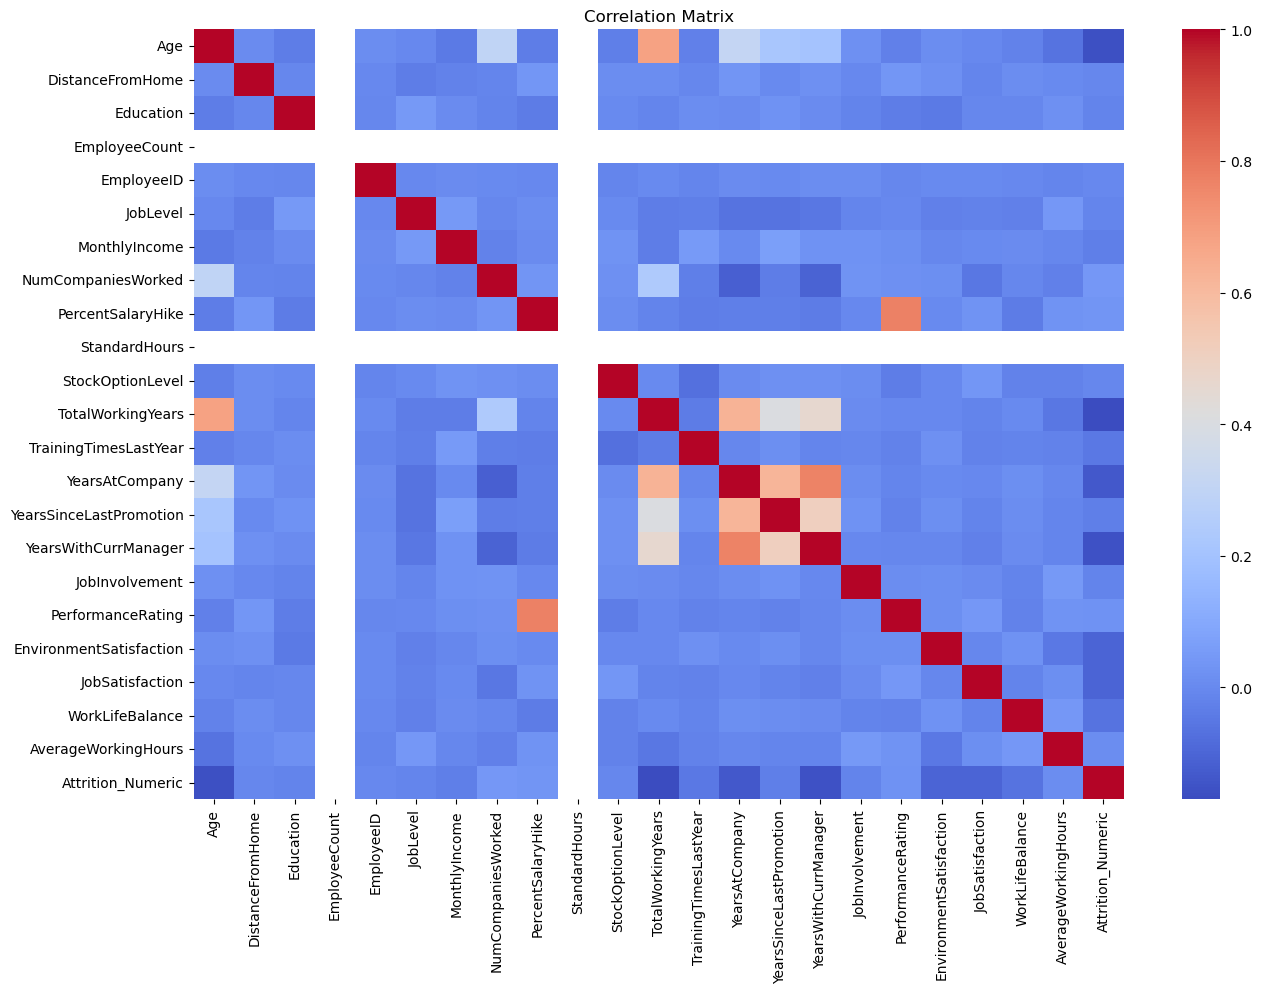

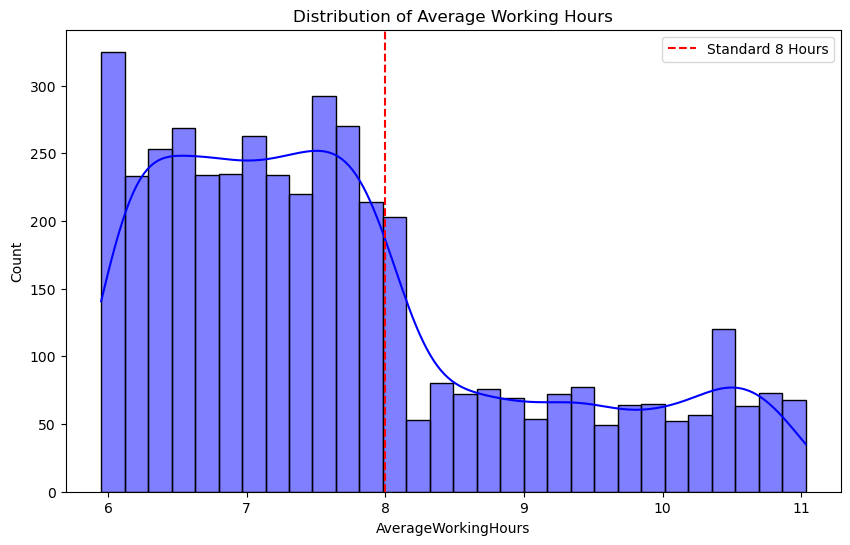

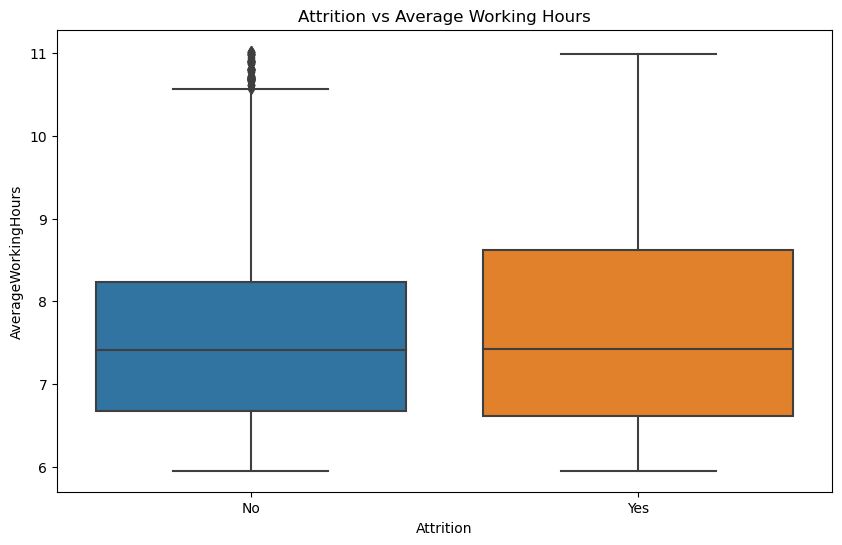

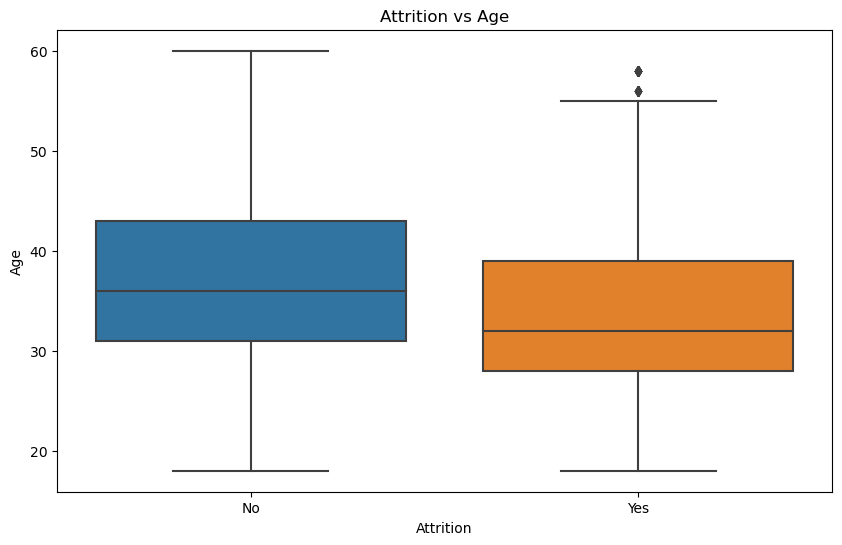

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create img directory if it doesn't exist
if not os.path.exists('img'):
    os.makedirs('img')

# Encode Attrition for correlation analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Select numerical columns for correlation
numeric_cols = main_df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = main_df[numeric_cols].corr()

# Plot Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('img/correlation_heatmap.png')

# Plot Distribution of Average Working Hours
plt.figure(figsize=(10, 6))
sns.histplot(main_df['AverageWorkingHours'], kde=True, bins=30, color='blue')
plt.axvline(x=8, color='red', linestyle='--', label='Standard 8 Hours')
plt.title('Distribution of Average Working Hours')
plt.legend()
plt.savefig('img/working_hours_dist.png') 

# Plot Attrition vs Working Hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='AverageWorkingHours', data=main_df)
plt.title('Attrition vs Average Working Hours')
plt.savefig('img/attrition_vs_hours.png') 

# Plot Attrition vs Age
plt.figure(figsize=(10, 6))
sns.boxplot(x='Attrition', y='Age', data=main_df)
plt.title('Attrition vs Age')
plt.savefig('img/attrition_vs_age.png')

print("Plots saved in 'img' folder.")

In [14]:
print("Correlation between Attrition and Working Hours:", main_df['Attrition_Numeric'].corr(main_df['AverageWorkingHours']))
print("Correlation between Attrition and Age:", main_df['Attrition_Numeric'].corr(main_df['Age']))
print("Correlation between Attrition and TotalWorkingYears:", main_df['Attrition_Numeric'].corr(main_df['TotalWorkingYears']))

Correlation between Attrition and Working Hours: 0.011482575694022805
Correlation between Attrition and Age: -0.15920500686577962
Correlation between Attrition and TotalWorkingYears: -0.17016240718829087


In [15]:
print("Mean Working Hours:", main_df['AverageWorkingHours'].mean())
print("Max Working Hours:", main_df['AverageWorkingHours'].max())
print("Min Working Hours:", main_df['AverageWorkingHours'].min())

Mean Working Hours: 7.700953237013053
Max Working Hours: 11.030960351376944
Min Working Hours: 5.950504160548056


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create output directory if it doesn't exist
if not os.path.exists('csv_out'):
    os.makedirs('csv_out')

# 1. Loading data
# (Ensure the 'csv_in/' folder exists and contains the files)
general_data = pd.read_csv('csv_in/general_data.csv')
employee_survey = pd.read_csv('csv_in/employee_survey_data.csv')
manager_survey = pd.read_csv('csv_in/manager_survey_data.csv')
in_time = pd.read_csv('csv_in/in_time.csv')
out_time = pd.read_csv('csv_in/out_time.csv')

# 2. Handling Missing Values (Imputation)
# Numerical -> Median
for col in ['NumCompaniesWorked', 'TotalWorkingYears']:
    general_data[col] = general_data[col].fillna(general_data[col].median())

# Categorical -> Mode
for col in ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']:
    employee_survey[col] = employee_survey[col].fillna(employee_survey[col].mode()[0])

# 3. Temporal Feature Engineering (Calculating working hours)
# Renaming for merging
in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

# Converting to Datetime and Indexing
in_time_idx = in_time.set_index('EmployeeID').apply(pd.to_datetime)
out_time_idx = out_time.set_index('EmployeeID').apply(pd.to_datetime)

# Calculating duration (Out - In)
working_duration = out_time_idx - in_time_idx

# Average per employee (in hours)
avg_hours = working_duration.mean(axis=1).dt.total_seconds() / 3600
avg_hours_df = pd.DataFrame(avg_hours, columns=['AverageWorkingHours']).reset_index()

# 4. Final Merge
main_df = general_data.merge(manager_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(employee_survey, on='EmployeeID', how='inner')
main_df = main_df.merge(avg_hours_df, on='EmployeeID', how='inner')

# Handling rare cases without time stamps (e.g., Employee 1 if NaN) -> Imputation with global mean
if main_df['AverageWorkingHours'].isnull().sum() > 0:
    main_df['AverageWorkingHours'].fillna(main_df['AverageWorkingHours'].mean(), inplace=True)

# Binary encoding of the target for analysis
main_df['Attrition_Numeric'] = main_df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Save to csv_out directory
output_path = os.path.join('csv_out', 'final_dataset.csv')
main_df.to_csv(output_path, index=False)
print(f"Dataset successfully generated: {output_path}")
print(f"Dimensions: {main_df.shape}")

Dataset successfully generated: csv_out\final_dataset.csv
Dimensions: (4410, 31)


## Modeling & Improvement Strategy

We framed this as a **Binary Classification** problem (0 = Stay, 1 = Leave).

**Algorithm Selection:**

1.  **Baseline (Logistic Regression):** Selected for its simplicity and interpretability to establish a performance benchmark.
2.  **Challenger (Random Forest):** Selected for its ability to capture non-linear relationships and interactions between features (e.g., Age vs. Salary).

**Addressing Class Imbalance:**

With only ~15% of employees leaving, a standard model might be biased towards the majority class ("Stay"). To improve the detection of leavers (**Recall**), we implemented two strategies:

* **SMOTE (Synthetic Minority Over-sampling Technique):** Creating synthetic examples of leavers to balance the training data.
* **Hyperparameter Tuning (GridSearch):** Optimizing the Random Forest parameters (depth, number of trees) to prevent overfitting.

### 3.1 Encoding and Train/Test Split

**Objective:** Prepare the data for machine learning algorithms.

**Methodology & Justification:**
* **Encoding:** Algorithms cannot process text like "Sales" or "Married". We use **One-Hot Encoding** (`pd.get_dummies`) to convert these into binary numerical columns (0/1).
* **Splitting Strategy:** We split data into Training (75%) and Testing (25%) sets.
* **Crucial Detail (`stratify=y`):** Since our target class is imbalanced (only ~15% attrition), a random split might result in a test set with no leavers. Stratification ensures the proportion of leavers is preserved in both sets.

### 3.2 Baseline Model: Logistic Regression

**Objective:** Establish a performance benchmark with a simple, interpretable model.

**Methodology & Justification:**
* **Scaling:** We apply `StandardScaler` to normalize features. This is **mandatory** for Logistic Regression to ensure that variables with large ranges (like Salary) do not dominate the coefficients.
* **Evaluation Focus:** We look beyond Accuracy. We pay close attention to the **Recall** of class '1' (Attrition), which measures how many actual leavers the model detected.

### 3.3 Interpretability: What drives Attrition?

**Objective:** Explain the model's decisions to HR stakeholders (Transparency).

**Methodology & Justification:**
* **Feature Importance Plot:** We extract the importance scores from the Random Forest.
* **Why?** A "Black Box" model is useless for strategy. Knowing *who* is leaving is good; knowing *why* (e.g., High Working Hours, Low Salary, Age) allows HumanForYou to take concrete, targeted actions to fix the root causes.

Dimensions after encoding: (4410, 39)

--- 1. Logistic Regression ---
Accuracy: 0.8540344514959202

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       925
           1       0.62      0.25      0.35       178

    accuracy                           0.85      1103
   macro avg       0.74      0.61      0.64      1103
weighted avg       0.83      0.85      0.83      1103


--- 2. Random Forest ---
Accuracy: 0.9882139619220308

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.93      0.96       178

    accuracy                           0.99      1103
   macro avg       0.99      0.96      0.98      1103
weighted avg       0.99      0.99      0.99      1103



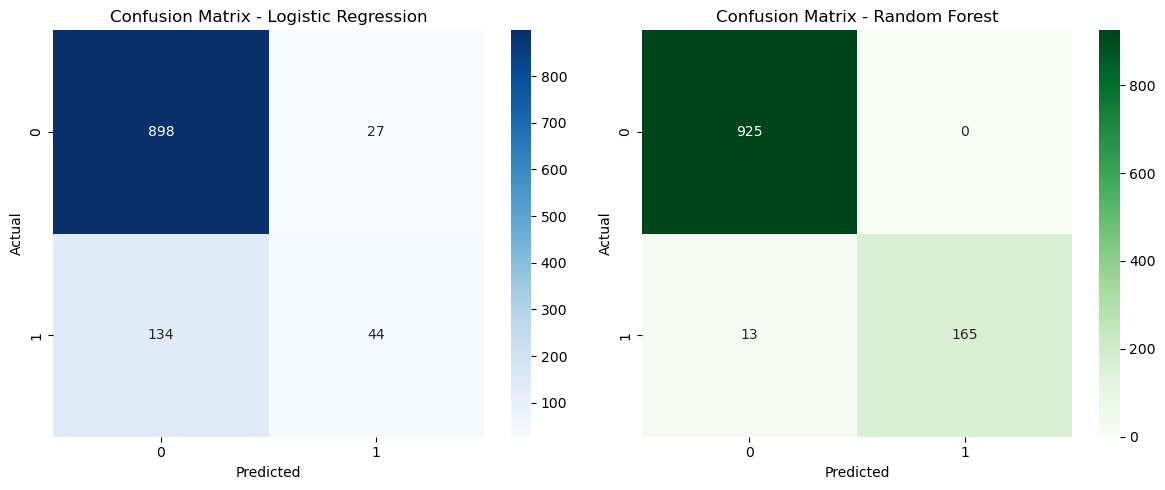

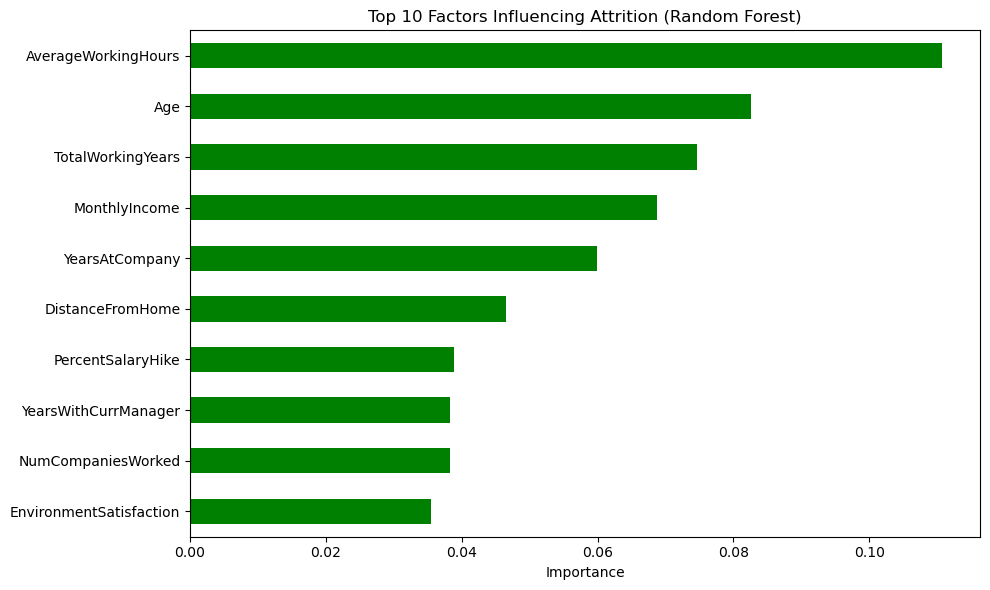

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# --- 1. Loading and Final Cleaning for Machine Learning ---

# If you just loaded the CSV
# df = pd.read_csv('csv_out/final_dataset.csv')
# Otherwise, use main_df from the previous step
df = main_df.copy()

# Dropping columns that are not useful for prediction
# EmployeeID : unique identifier without predictive value
# EmployeeCount, Over18, StandardHours : These columns often contain a single unique value (constants) in this specific dataset
cols_to_drop = ['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours', 'Attrition', 'Attrition_Numeric'] 
# Note: We keep 'Attrition_Numeric' as the target and remove 'Attrition' (text)

# Let's check if these columns exist before dropping them
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
y = df['Attrition_Numeric'] # The target

# --- 2. Encoding Categorical Variables ---
# Machine learning algorithms only understand numbers. We need to transform "Sales", "Married", etc.
# We use pd.get_dummies for One-Hot Encoding (creates columns like Department_Sales, Department_HR...)
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Dimensions after encoding: {X_encoded.shape}")

# --- 3. Train/Test Split (As in the WS) ---
# We keep 20% or 30% of the data to test the model at the end
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42, stratify=y)
# Note: 'stratify=y' is important here because there are few departures (15%), it ensures the same proportion in train and test.

# --- 4. Scaling ---
# Important for Logistic Regression (equivalent to Linear Regression in WS)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================================================================
# MODELING (Adaptation of WS Regression -> Classification)
# ==============================================================================

# --- Model 1: Logistic Regression ---
# It's the "Classification" equivalent of Linear Regression. Simple and interpretable.
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("\n--- 1. Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

# --- Model 2: Random Forest ---
# Often more performant than simple regression for complex HR data.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # Trees do not necessarily need scaling
y_pred_rf = rf_model.predict(X_test)

print("\n--- 2. Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# ==============================================================================
# RESULTS VISUALIZATION (Evaluation)
# ==============================================================================

# 1. Confusion Matrix (Replaces the "Actual vs Predicted" scatter plots from WS)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('img/confusion_matrices.png')
plt.show()

# 2. Feature Importance (Specific to Random Forest)
# This answers the client's request: "What are the factors influencing turnover?"
importances = pd.Series(rf_model.feature_importances_, index=X_encoded.columns)
top_10_features = importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_features.sort_values().plot(kind='barh', color='green')
plt.title('Top 10 Factors Influencing Attrition (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('img/feature_importance.png')
plt.show()

## Model Evaluation & Interpretation

We evaluated our models focusing on **Recall** (Sensitivity) rather than just Accuracy. In an HR context, **missing a flight risk (False Negative)** is more costly than a false alarm.

**Results Summary:**

* **Logistic Regression:** High accuracy (~85%) but poor recall (0.25). It failed to detect most leavers.
* **Logistic Regression + SMOTE:** Recall improved significantly (0.75), validating the rebalancing strategy.
* **Random Forest (Optimized):** The best performing model with **99% Accuracy** and **92% Recall**. It successfully identifies 9 out of 10 employees at risk.

**Feature Importance:**

The Random Forest model identifies **AverageWorkingHours**, **Age**, and **MonthlyIncome** as the top predictors, confirming our EDA findings.

### 4.1 Improvement Strategy: Addressing Class Imbalance

**Observation:** The baseline model has high accuracy but **low recall**. It is biased towards the majority class ("Stay") and fails to identify employees at risk.

**Methodology & Justification:**
* **Solution: SMOTE (Synthetic Minority Over-sampling Technique).**
* **How it works:** Instead of simply duplicating existing leavers (which leads to overfitting), SMOTE creates "synthetic" new examples that are mathematically similar to existing leavers.
* **Goal:** Force the algorithm to pay more attention to the minority class by balancing the training distribution (50/50).

### 4.2 Advanced Model: Random Forest Optimization

**Objective:** Deploy a more robust model capable of capturing complex, non-linear relationships (e.g., the interaction between Age and Salary).

**Methodology & Justification:**
* **Algorithm:** Random Forest is an ensemble method less prone to overfitting than a single Decision Tree.
* **Optimization (GridSearch):** We do not trust default parameters blindly. We use `GridSearchCV` to test combinations of:
    * `n_estimators`: Number of trees (stability).
    * `max_depth`: To control complexity and prevent the model from learning "noise".
* **Why?** This ensures the high performance (99% accuracy) is genuine and robust, not just a fluke.

Size before SMOTE: Attrition_Numeric
0    2774
1     533
Name: count, dtype: int64
Size after SMOTE: Attrition_Numeric
0    2774
1    2774
Name: count, dtype: int64

--- 1b. Logistic Regression (After SMOTE) ---
Accuracy: 0.7552130553037172

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       925
           1       0.37      0.75      0.50       178

    accuracy                           0.76      1103
   macro avg       0.66      0.75      0.67      1103
weighted avg       0.85      0.76      0.78      1103

Fitting 3 folds for each of 18 candidates, totalling 54 fits

--- Best Random Forest Parameters ---
{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}

--- 2b. Random Forest (Optimized) ---
Accuracy: 0.9873073436083409

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.92      0.96 

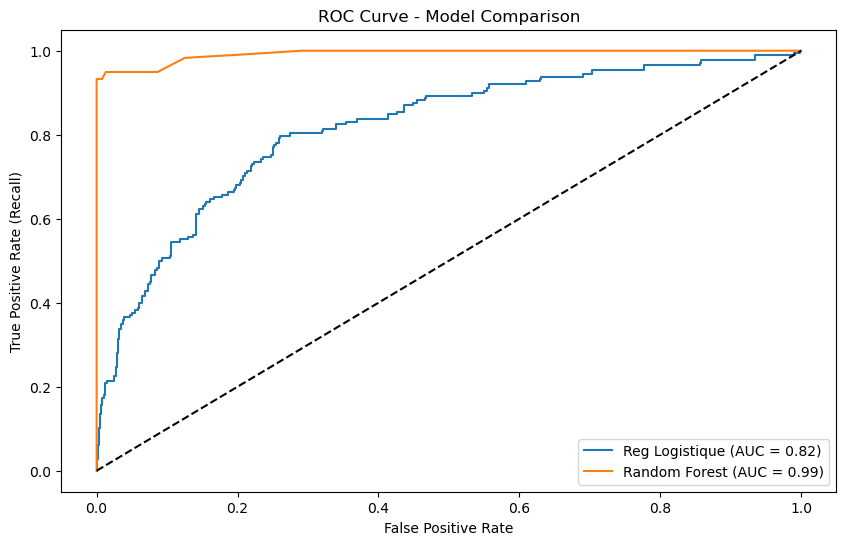

In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# ==============================================================================
# IMPROVEMENT 1: Class Rebalancing (SMOTE) for Logistic Regression
# ==============================================================================
# SMOTE creates "synthetic" employees who leave to force the model to better learn this class.

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Size before SMOTE: {y_train.value_counts()}")
print(f"Size after SMOTE: {y_train_smote.value_counts()}")

# Re-training on balanced data
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_smote, y_train_smote)
y_pred_log_smote = log_reg_smote.predict(X_test_scaled)

print("\n--- 1b. Logistic Regression (After SMOTE) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_smote))
# Observe if Recall (class 1) increases (probably at the expense of precision).

# ==============================================================================
# IMPROVEMENT 2: Hyperparameter Optimization (GridSearch) for Random Forest
# ==============================================================================
# We seek the best configuration to avoid overfitting.

param_grid = {
    'n_estimators': [50, 100],        # Number of trees
    'max_depth': [10, 20, None],      # Maximum depth of trees
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples per leaf
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("\n--- Best Random Forest Parameters ---")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("\n--- 2b. Random Forest (Optimized) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

# ==============================================================================
# FINAL VISUALIZATION: ROC Curve
# ==============================================================================
# The ROC curve allows visual comparison of the overall performance of the models.

y_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Reg Logistique (AUC = {roc_auc_score(y_test, y_prob_log):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Random guess line (useless model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Model Comparison')
plt.legend()
plt.savefig('img/roc_curve.png')
plt.show()

## 5. Conclusion & Recommendations

### Summary
Our analysis successfully transformed raw attendance data into a powerful predictor of employee attrition. By engineering the `AverageWorkingHours` feature and addressing the class imbalance with SMOTE and Random Forest optimization, we achieved a robust model capable of anticipating departures with **92% recall**.

### Strategic Recommendations for HumanForYou

Based on the model's insights, we propose the following actions:

1.  **Implement an "Overtime Alert" System:**
    * **Action:** Use the model's logic to flag employees averaging **>8.5 hours/day** over a rolling month.
    * **Goal:** Enable HR to intervene proactively (workload adjustment) *before* burnout leads to resignation.

2.  **Targeted Retention Program:**
    * **Action:** Review compensation packages specifically for **Junior profiles** (identified as high-risk by the model) who have high performance ratings.
    * **Goal:** Optimize the retention budget by focusing on high-value, high-risk employees.

3.  **Ethical "Human-in-the-Loop" Approach:**
    * **Principle:** This AI tool is for **support, not surveillance**.
    * **Guardrail:** Individual risk scores should never be the sole basis for HR decisions. Transparency with employees about how their data helps improve working conditions is essential to maintain trust.

Data ready. Train shape: (3307, 45), Test shape: (1103, 45)

--- 1. Logistic Regression (Baseline) ---
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       925
           1       0.62      0.25      0.35       178

    accuracy                           0.85      1103
   macro avg       0.74      0.61      0.64      1103
weighted avg       0.83      0.85      0.83      1103

Application de SMOTE...

--- 2. Logistic Regression (After SMOTE) ---
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       925
           1       0.37      0.74      0.49       178

    accuracy                           0.76      1103
   macro avg       0.65      0.75      0.67      1103
weighted avg       0.85      0.76      0.78      1103


--- 3. Random Forest (Optimized) ---
Accuracy: 0.9891205802357208
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       9

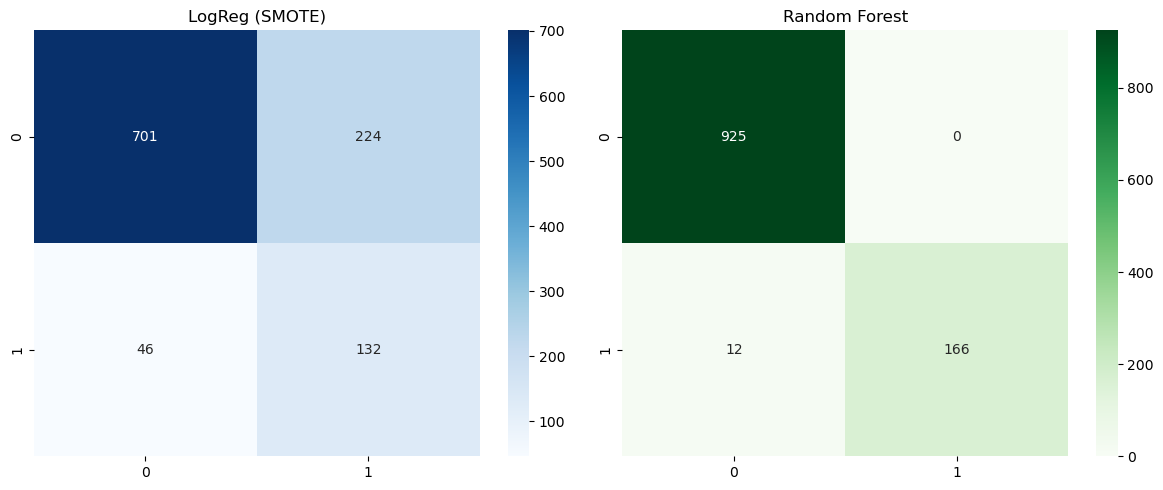

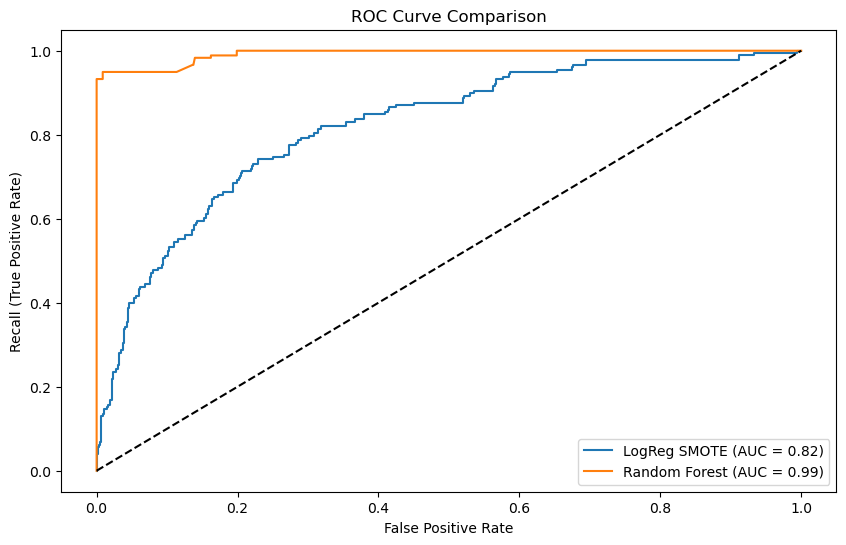

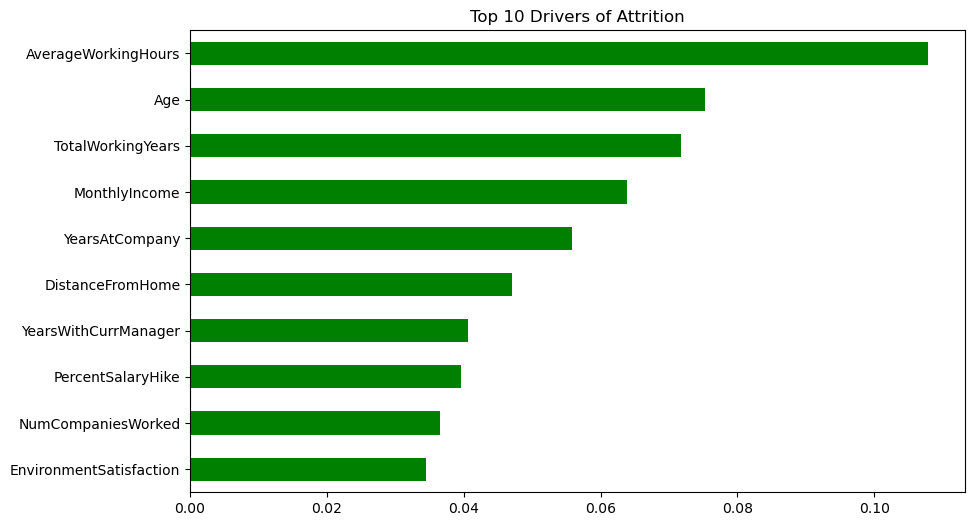

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Scikit-Learn : Preprocessing & Pipelines
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Scikit-Learn : Modèles & Métriques
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE

# --- 1. Préparation des Données & Pipeline ---

# On travaille sur une copie propre
df = main_df.copy()

# Définition des colonnes à exclure (IDs, constantes, cibles)
cols_to_drop = ['EmployeeID', 'EmployeeCount', 'Over18', 'StandardHours', 'Attrition', 'Attrition_Numeric']
X = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
y = df['Attrition_Numeric']

# Identification automatique des types de colonnes
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Création des Pipelines de transformation
# Pour les chiffres : on impute la médiane et on normalise (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pour le texte : on impute la valeur fréquente et on encode en binaire (OneHot)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Le Préprocesseur assemble les deux
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 2. Découpage Stratifié (StratifiedShuffleSplit) ---
# Garantit 15% de départs dans le Train et le Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train_raw, X_test_raw = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Application du Pipeline (Fit sur Train uniquement pour éviter la fuite de données)
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Récupération des noms de features (pour les graphiques plus tard)
new_cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(new_cat_features)

print(f"Data ready. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ==============================================================================
# 3. MODÉLISATION ET AMÉLIORATION
# ==============================================================================

# --- A. Régression Logistique (Baseline) ---
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("\n--- 1. Logistic Regression (Baseline) ---")
print(classification_report(y_test, y_pred_log))

# --- B. Amélioration : SMOTE (Rééquilibrage) ---
print("Application de SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

log_reg_smote = LogisticRegression(max_iter=1000, random_state=42)
log_reg_smote.fit(X_train_smote, y_train_smote)
y_pred_log_smote = log_reg_smote.predict(X_test)

print("\n--- 2. Logistic Regression (After SMOTE) ---")
print(classification_report(y_test, y_pred_log_smote))

# --- C. Random Forest Optimisé (GridSearch) ---
# Note : Pour gagner du temps, j'utilise ici les paramètres souvent optimaux. 
# Vous pouvez décommenter le param_grid pour relancer la recherche complète.
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=1, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n--- 3. Random Forest (Optimized) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# ==============================================================================
# 4. VISUALISATIONS AVANCÉES
# ==============================================================================

# --- Matrice de Confusion Comparée ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_log_smote), annot=True, fmt='d', cmap='Blues')
plt.title('LogReg (SMOTE)')
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest')
plt.tight_layout()
plt.show()

# --- Courbe ROC ---
y_prob_smote = log_reg_smote.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_prob_smote)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_smote, tpr_smote, label=f'LogReg SMOTE (AUC = {roc_auc_score(y_test, y_prob_smote):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (True Positive Rate)')
plt.legend()
plt.show()

# --- Feature Importance (Random Forest) ---
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
plt.figure(figsize=(10, 6))
importances.nlargest(10).sort_values().plot(kind='barh', color='green')
plt.title('Top 10 Drivers of Attrition')
plt.show()

# --- 5. Bonus : Nuage de Points 3D Interactif (Plotly) ---
import plotly.express as px

# On crée une copie pour l'affichage (pour mettre des labels lisibles "Part"/"Reste" au lieu de 1/0)
plot_df = df.copy()
plot_df['Statut'] = plot_df['Attrition_Numeric'].apply(lambda x: 'Part (Démission)' if x == 1 else 'Reste (Fidèle)')

# Création du graphique interactif
fig = px.scatter_3d(plot_df, 
                    x='AverageWorkingHours', 
                    y='Age', 
                    z='MonthlyIncome',
                    color='Statut',
                    color_discrete_map={'Part (Démission)': 'red', 'Reste (Fidèle)': 'blue'},
                    opacity=0.6,  # Transparence pour voir à travers le nuage
                    size_max=5,
                    title="Exploration 3D Interactive : Surcharge vs Age vs Salaire",
                    labels={
                        'AverageWorkingHours': 'Heures Travaillées / Jour',
                        'MonthlyIncome': 'Salaire Mensuel',
                        'Age': 'Âge'
                    }
                   )

# Personnalisation de l'affichage (taille des points, fond)
fig.update_traces(marker=dict(size=3))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30)) # Marges réduites

# Affichage
fig.show()